In [1]:
import torch
import torchvision
import torch.nn as nn
from datasets.SSL4EO.ssl4eo_dataset_lmdb_mm import LMDBDataset
from cvtorchvision import cvtransforms
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import time
import os
from tqdm import tqdm
import torch.nn.functional as F

/p/project/hai_dm4eo/wang36/jupyter/kernels/wang36_kernel/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class TwoCropsTransform:
    """Take two random crops of one image as the query and key."""

    def __init__(self, base_transform, season='fixed'):
        self.base_transform = base_transform
        self.season = season

    def __call__(self, x):

        if self.season=='augment':
            season1 = np.random.choice([0,1,2,3])
            season2 = np.random.choice([0,1,2,3])
        elif self.season=='fixed':
            np.random.seed(42)
            season1 = np.random.choice([0,1,2,3])
            season2 = season1
        elif self.season=='random':
            season1 = np.random.choice([0,1,2,3])
            season2 = season1

        x1 = np.transpose(x[season1,:,:,:],(1,2,0))
        #x2 = np.transpose(x[season2,:,:,:],(1,2,0))

        q = self.base_transform(x1)
        #k = self.base_transform(x2)

        #return [q, k]
        return q

In [3]:
data1 = '/p/project/hai_dm4eo/wang_yi/data/251k_sar.lmdb'
data2 = '/p/project/hai_dm4eo/wang_yi/data/251k_ms.lmdb'
season = 'fixed'

In [4]:
from models.rs_transforms_uint8 import RandomChannelDrop,RandomBrightness,RandomContrast,ToGray

train_transforms_s1 = cvtransforms.Compose([
    #cvtransforms.Resize(128),
    cvtransforms.CenterCrop(224),
    #cvtransforms.RandomResizedCrop(224, scale=(0.2, 1.)),
    #cvtransforms.RandomApply([
    #    RandomBrightness(0.4),
    #    RandomContrast(0.4)
    #], p=0.8),
    #cvtransforms.RandomApply([ToGray(2)], p=0.2),
    #cvtransforms.RandomApply([loader.GaussianBlur([.1, 2.])], p=0.5),
    #cvtransforms.RandomHorizontalFlip(),       
    cvtransforms.ToTensor()
    #cvtransforms.RandomApply([RandomChannelDrop(min_n_drop=1, max_n_drop=6)], p=0.5),        
    ])


train_transforms_s2c = cvtransforms.Compose([
    #cvtransforms.Resize(128),
    cvtransforms.CenterCrop(224),
    #cvtransforms.RandomResizedCrop(224, scale=(0.2, 1.)),
    #cvtransforms.RandomApply([
    #    RandomBrightness(0.4),
    #    RandomContrast(0.4)
    #], p=0.8),
    #cvtransforms.RandomApply([ToGray(13)], p=0.2),
    #cvtransforms.RandomApply([loader.GaussianBlur([.1, 2.])], p=0.5),
    #cvtransforms.RandomHorizontalFlip(),       
    cvtransforms.ToTensor()
    #cvtransforms.RandomApply([RandomChannelDrop(min_n_drop=1, max_n_drop=6)], p=0.5),        
    ])


train_dataset = LMDBDataset(
    lmdb_file_s1=data1,
    lmdb_file_s2=data2,
    s1_transform= TwoCropsTransform(train_transforms_s1,season=season),
    s2c_transform=TwoCropsTransform(train_transforms_s2c,season=season),
    is_slurm_job=True,
    normalize=False,
    dtype1='float32',
    dtype2='uint8',
    mode=['s1','s2c']
)   


train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=128, shuffle=False,
    num_workers=0, drop_last=True)

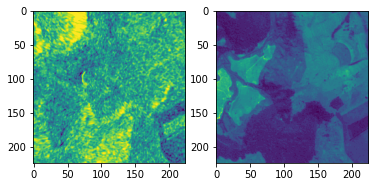

In [5]:
## visualize
img_sar = train_dataset[10][0]
img_ms = train_dataset[10][1]
plt.subplot(1,2,1)
plt.imshow(img_sar[0])
plt.subplot(1,2,2)
plt.imshow(img_ms[1])

In [6]:
def off_diagonal(x):
    # return a flattened view of the off-diagonal elements of a square matrix
    n, m = x.shape
    assert n == m
    return x.flatten()[:-1].view(n - 1, n + 1)[:, 1:].flatten()

class BarlowTwins(torch.nn.Module):
    def __init__(self):
        super().__init__()

        self.backbone_1 = torchvision.models.resnet50(zero_init_residual=True)
        self.backbone_2 = torchvision.models.resnet50(zero_init_residual=True)

        self.backbone_1.conv1 = torch.nn.Conv2d(2, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)            
        self.backbone_2.conv1 = torch.nn.Conv2d(13, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

        self.backbone_1.fc = nn.Identity()
        self.backbone_2.fc = nn.Identity()

        
        # projector
        sizes = [2048] + list(map(int, '512-512-512'.split('-')))
        #sizes = [2048] + list(map(int, '8192-8192-8192'.split('-')))

        layers = []
        for i in range(len(sizes) - 2):
            layers.append(nn.Linear(sizes[i], sizes[i + 1], bias=False))
            layers.append(nn.BatchNorm1d(sizes[i + 1]))
            layers.append(nn.ReLU(inplace=True))
        layers.append(nn.Linear(sizes[-2], sizes[-1], bias=False))
        self.projector1 = nn.Sequential(*layers)
        self.projector2 = nn.Sequential(*layers)

        # normalization layer for the representations z1 and z2        
        self.bn = nn.BatchNorm1d(sizes[-1], affine=False)
        
        #self.bn = nn.BatchNorm1d(2048, affine=False)

    def forward(self, y1, y2):
        z1 = self.projector1(self.backbone_1(y1))
        z2 = self.projector2(self.backbone_2(y2))
        #z1 = self.backbone_1(y1)
        #z2 = self.backbone_2(y2)        

        # empirical cross-correlation matrix
        #c = self.bn(z1).T @ self.bn(z2)

        # sum the cross-correlation matrix between all gpus
        #c.div_(128)
        #torch.distributed.all_reduce(c)

        #on_diag = torch.diagonal(c).add_(-1).pow_(2).sum()
        #off_diag = off_diagonal(c).pow_(2).sum()
        #loss = on_diag + self.args.lambd * off_diag
        #return loss,on_diag,off_diag
        return self.bn(z1),self.bn(z2)

In [7]:
resume = '/p/project/hai_dm4eo/wang_yi/ssl4eo-mm-v3/src/pretrain/checkpoints/late_fusion_2p2/B2B13_bt_decu_rn50/checkpoint_0099.pth'
#resume = '/p/project/hai_dm4eo/wang_yi/ssl4eo-mm-v3/src/pretrain/checkpoints/late_fusion_2p2/B2B13_bt_decu_rn50_prj8192/checkpoint_0099.pth'
#resume = '/p/project/hai_dm4eo/wang_yi/ssl4eo-mm-v3/src/pretrain/checkpoints/feature/B2B13_bt_mm2_decu_rn50/checkpoint_0099.pth'

model = BarlowTwins()
#model.cuda()
ckpt = torch.load(resume, map_location='cpu')
state_dict = ckpt['model']
state_dict = {k.replace("module.", ""): v for k,v in state_dict.items()}
model.load_state_dict(state_dict)

<All keys matched successfully>

In [8]:
id = 9
model.eval()
feature_bank = []
targets = []
with torch.no_grad():  
    for i,data in enumerate(train_loader):
        if i<id:
            continue
        if i>id:
            break       
        z1,z2 = model.forward(data[0], data[1])
        feature = torch.cat((z1[:,:448],z2[:,:448],z1[:,448:],z2[:,448:]),-1) # N,2C (N,c+c+u1+u2)
        feature = F.normalize(feature, dim=0)
        feature_bank.append(feature)

    feature_data = torch.cat(feature_bank,0).cpu().permute(1,0)
    
    target_data = torch.zeros(1024,dtype=torch.int)
    target_data[448:896] = 1
    target_data[896:960] = 2
    target_data[960:1024] = 3

In [19]:
#np.save('results/tsne_feature_b2.npy',feature_data)

In [9]:
df = pd.DataFrame(feature_data)
df['y'] = target_data
#pca = PCA(n_components=50)
#pca_result = pca.fit_transform(feature_data)
pca_result = feature_data

In [35]:
time_start = time.time()
tsne = TSNE(n_components=2, verbose=2, perplexity=40, n_iter=2000, n_iter_without_progress=300)
tsne_results = tsne.fit_transform(pca_result)
tsne_time = time.time()-time_start
print('t-SNE done! Time elapsed: {} seconds'.format(tsne_time))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1024 samples in 0.008s...
[t-SNE] Computed neighbors for 1024 samples in 0.211s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1024
[t-SNE] Computed conditional probabilities for sample 1024 / 1024
[t-SNE] Mean sigma: 0.509631
[t-SNE] Computed conditional probabilities in 0.047s
[t-SNE] Iteration 50: error = 67.9905319, gradient norm = 0.1522328 (50 iterations in 0.180s)
[t-SNE] Iteration 100: error = 67.9861221, gradient norm = 0.1465623 (50 iterations in 0.291s)
[t-SNE] Iteration 150: error = 67.9859543, gradient norm = 0.1381954 (50 iterations in 0.289s)
[t-SNE] Iteration 200: error = 67.9722748, gradient norm = 0.1252683 (50 iterations in 0.222s)
[t-SNE] Iteration 250: error = 67.9960709, gradient norm = 0.1502993 (50 iterations in 0.287s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 67.996071
[t-SNE] Iteration 300: error = 1.5285653, gradient norm = 0.0014494 (50 iterations in 0.296s

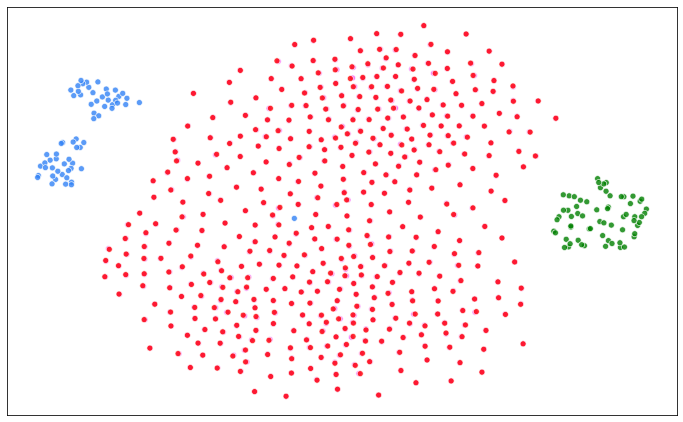

In [36]:
df['tsne-2d-one'] = tsne_results[:,0]
df['tsne-2d-two'] = tsne_results[:,1]
plt.figure(figsize=(12,7.5))
tsne_plot = sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="y",
    palette=sns.color_palette(palette=['#F85AF5','r','g','#3282F6'],n_colors=4),
    data=df,
    legend=None,
    alpha=0.8
)

tsne_plot.set(xticklabels=[])  # remove the tick labels
tsne_plot.set(yticklabels=[])  # remove the tick labels
tsne_plot.set(xlabel=None)  # remove the axis label
tsne_plot.set(ylabel=None)  # remove the axis label
tsne_plot.tick_params(bottom=False,left=False)
fig = tsne_plot.get_figure()

fig.savefig('../../results/appendix/tsne_BE_batch_{}.pdf'.format(id),transparent=True,bbox_inches="tight")